In [146]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial
from matrix_calculator import A_matrix

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [147]:
N = 200
r_in = 0.01 # AU
r_out = 1e4 # AU 
r = np.logspace(np.log(r_in), np.log(r_out), N, base = np.exp(1))
r_au = r * u.au
r_log = np.log(r)
Δr_log = r_log[1] - r_log[0]

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$

### Temperature from irradition
$$T_{1au}=280K\quad p=-1/2$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

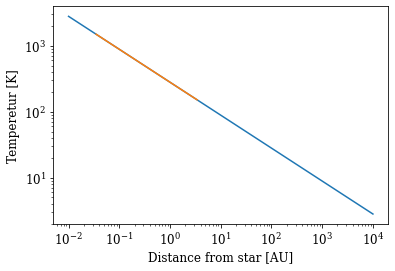

In [148]:
T_1au = 280 * u.K
p = -1/2

T_req = T_1au * (r)**p
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

In [149]:
D1_log = A_matrix(4, 1, N) / Δr_log
sD1_log = csr_matrix(D1_log.copy())

Text(0.5, 0, 'Distance from star [AU]')

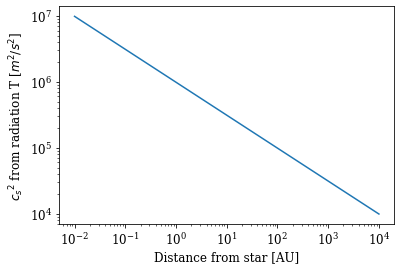

In [150]:
def c_s2(T):
    μ = 2.34
    return ((k_B * T) / (μ * m_p)).decompose()

plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{3\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the strong DW case (p. 4 Suzuki)
$$F_{rad} = max\left(-\frac{1}{r}\partial_r r^2 \Sigma \Omega α_{rφ} c_s^2,\;0\right)$$
$$[r^2 \Sigma \Omega α_{rφ} c_s^2] = \frac{m^2kg}{s^3}\quad\Rightarrow\quad [F_{rad}]=\frac{kg}{s^3}$$


1 / s
5.6703744191844314e-08 kg / (K4 s3)


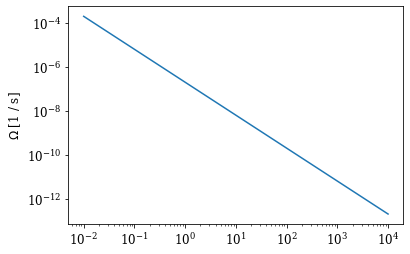

In [174]:
Ω = (np.sqrt((G * M_sun) / r_au**3)).decompose()
plt.loglog(r, Ω)
plt.ylabel(f'$\Omega$ [{Ω.unit}]')
print(Ω.unit) 
print(sigma_sb.decompose())

Unit("kg m2 / s3")

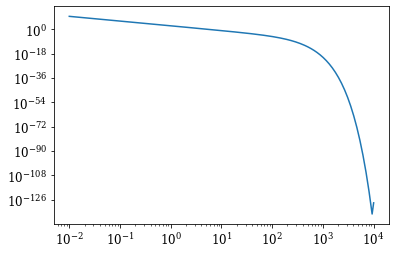

In [152]:
α_rφ = 8e-3
func_to_der = (r_au**2 * Σ_initial(r_au) * Ω * α_rφ * c_s2(T_req)).decompose()
F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()

plt.loglog(r, F_rad)
F_rad[F_rad < 0]
func_to_der.unit

In [153]:
test = np.array([3])
type(test) == np.ndarray
type(T_req)

astropy.units.quantity.Quantity

In [154]:
### Opacity ###
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 

    κ[TT > 1500] = 0 # Støvet fordamper og går i stykker 

    return κ * (Σ.to('g/cm2')).value / 2


def tau_P(τ_R):
    τ_P = τ_R.copy()
    τ_P[2.4 * τ_P <= 0.5] = 0.5
    τ_P[2.4 * τ_P > 0.5] = 2.4 * τ_P[2.4 * τ_P > 0.5]
    return τ_P

In [155]:
def F_rad_func(Σ, cs2):
    func_to_der = (r_au**2 * Σ * Ω * α_rφ * cs2).decompose()
    F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()
    F_rad_nounit = F_rad.value
    F_rad_nounit[F_rad_nounit <= 0] = 0
    return F_rad_nounit * F_rad.unit

In [156]:
F_rad_func(Σ_initial(r_au), c_s2(T_req)).to('W/m2') # It's a flux

<Quantity [4.01022652e+009, 3.15159872e+009, 2.47172166e+009,
           1.93850954e+009, 1.52032360e+009, 1.19235019e+009,
           9.35128475e+008, 7.33395746e+008, 5.75181770e+008,
           4.51098553e+008, 3.53783294e+008, 2.77461508e+008,
           2.17604395e+008, 1.70660121e+008, 1.33843061e+008,
           1.04968516e+008, 8.23230767e+007, 6.45629584e+007,
           5.06342630e+007, 3.97104447e+007, 3.11432647e+007,
           2.44243260e+007, 1.91549066e+007, 1.50222994e+007,
           1.17812572e+007, 9.23943947e+006, 7.24599931e+006,
           5.68263200e+006, 4.45655482e+006, 3.49500130e+006,
           2.74090308e+006, 2.14950341e+006, 1.68570115e+006,
           1.32196778e+006, 1.03671370e+006, 8.13007073e+005,
           6.37568929e+005, 4.99985150e+005, 3.92088407e+005,
           3.07473440e+005, 2.41116918e+005, 1.89079295e+005,
           1.48270995e+005, 1.16269036e+005, 9.11732136e+004,
           7.14933147e+004, 5.60606611e+004, 4.39587377e+004,
        

348.5329658998226 W / m2


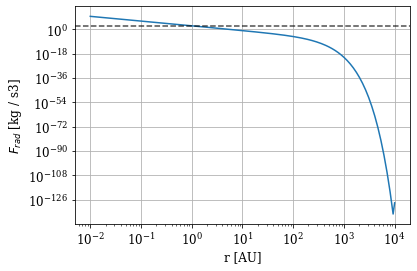

In [177]:
plt.loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T_req)))
plt.grid()
plt.ylabel('$F_{rad}$'+f' [{F_rad_func(Σ_initial(r_au), c_s2(T_req)).unit}]')
plt.xlabel(f'r [{r_au.unit}]')
print(sigma_sb*(280 *u.K)**4)
plt.axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black')
#plt.ylim(1,1000)

In [158]:
def T_vis(T, Σ):
    return ((0.5 * sigma_sb**(-1) * (3/8 * tau_R(T, Σ) + 0.5 * tau_P(tau_R(T, Σ))**(-1)) * F_rad_func(Σ, c_s2(T)))**(0.25)).decompose()

In [159]:
T_vis(T_req, Σ_initial(r_au))

<Quantity [1.10173966e+04, 1.03733608e+04, 9.76195153e+03, 9.18657748e+03,
           8.64511482e+03, 8.13556487e+03, 7.65604675e+03, 7.20479044e+03,
           6.78013022e+03, 6.38049856e+03, 6.00442033e+03, 5.65050732e+03,
           5.31745315e+03, 5.00402843e+03, 4.70907624e+03, 4.43150783e+03,
           4.17029862e+03, 3.92448444e+03, 1.76999689e+05, 1.62282600e+05,
           1.48788903e+05, 1.36416905e+05, 1.25073367e+05, 1.14672800e+05,
           1.05136822e+05, 9.63935648e+04, 8.83771345e+04, 8.10271147e+04,
           7.42881110e+04, 6.81093332e+04, 6.24442131e+04, 5.72500534e+04,
           5.24877057e+04, 4.81212760e+04, 4.41178536e+04, 4.04472636e+04,
           3.70818394e+04, 3.39962138e+04, 3.11671285e+04, 2.85732584e+04,
           2.61950509e+04, 2.40145788e+04, 2.20154050e+04, 2.01824587e+04,
           1.85019219e+04, 1.69611251e+04, 1.55484519e+04, 1.42532517e+04,
           1.30657589e+04, 1.19770200e+04, 1.09788254e+04, 1.00636483e+04,
           9.22458711e+03

In [160]:
T_req

<Quantity [2800.        , 2704.47302752, 2612.20512736, 2523.08511047,
           2437.00558122, 2353.86280797, 2273.55659809, 2195.99017717,
           2121.07007246, 2048.70600016, 1978.8107567 , 1911.3001136 ,
           1846.09271597, 1783.10998452, 1722.2760208 , 1663.51751579,
           1606.76366152, 1551.94606579, 1498.99866968, 1447.85766801,
           1398.46143244, 1350.75043717, 1304.66718723, 1260.1561492 ,
           1217.16368428, 1175.63798364, 1135.52900604, 1096.78841743,
           1059.3695328 , 1023.22725987,  988.31804476,  954.59981953,
            922.03195143,  890.57519398,  860.19163968,  830.84467429,
            802.49893275,  775.12025651,  748.67565244,  723.13325299,
            698.46227786,  674.63299687,  651.61669411,  629.38563339,
            607.91302479,  587.17299237,  567.14054298,  547.79153618,
            529.10265511,  511.05137841,  493.61595307,  476.77536822,
            460.50932984,  444.79823624,  429.6231545 ,  414.96579762,
      

(1, 1000000.0)

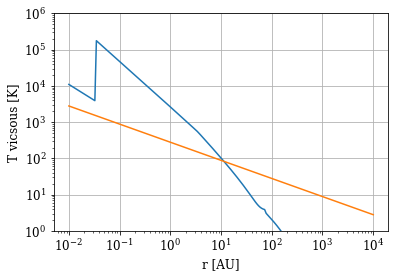

In [161]:
plt.loglog(r, T_vis(T_req, Σ_initial(r_au)))
plt.loglog(r, T_req)
plt.grid()
plt.ylabel('T vicsous'+f' [{T_vis(T_req, Σ_initial(r_au)).unit}]')
plt.xlabel(f'r [{r_au.unit}]')
plt.ylim(1, 1e6)
# Falder opaciteten altså den bliver gennemsigtig falder temperaturen fordi der ikke er noget til at holde på varmen

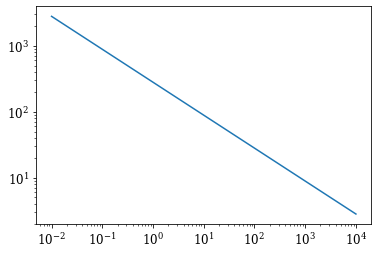

In [162]:
plt.loglog(r, T_req)

In [163]:
def T_func(T, Σ):
    return (T_vis(T, Σ_initial(r_au)).value**4 + T_req.value**4 - T.value**4)**0.25

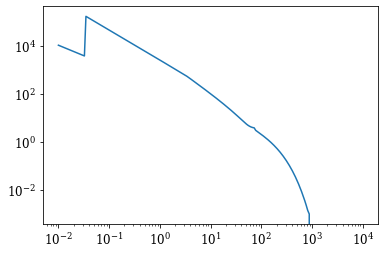

In [164]:
plt.loglog(r, T_func(T_req, Σ_initial(r_au)))

In [165]:
def func(T):
    T_new4 = T_vis(T, Σ_initial(r_au)).value**4 + T_req.value**4
    return T_new4**0.25 * u.K

In [166]:
func(T_req).unit

Unit("K")

Text(0.5, 0, 'R [AU]')

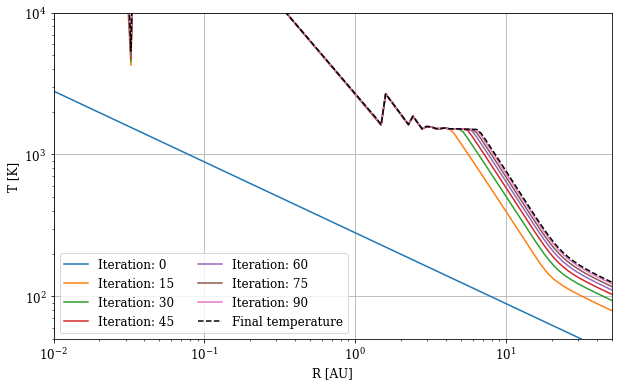

In [185]:
T0 = T_req
T = [T_req]
for i in range(100):
    T_new = func(T[-1])
    T_damp = (T[-1]**4 + T_new**4)**0.25
    T.append(T_damp)


plt.figure(figsize = (10,6))
plt.grid()
for i, t in enumerate(T):
    if i%15 == 0:
        plt.loglog(r, t, label=f'Iteration: {i}')
plt.loglog(r, T[-1], ls='--', c='black', label = 'Final temperature')
plt.legend(ncol = 2)
plt.ylim(50,1e4)
plt.xlim(0.01, 50)
plt.ylabel(f'T [{T_damp.unit}]')
plt.xlabel('R [AU]')

Text(0.5, 0, 'Distance [AU]')

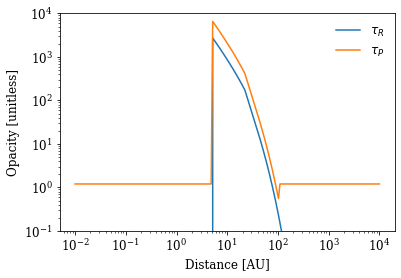

In [172]:
plt.loglog(r, tau_R(T[-1], Σ_initial(r_au)), label = '$τ_R$')
plt.loglog(r, tau_P(tau_R(T[-1], Σ_initial(r_au))), label = '$τ_P$')
plt.ylim(0.1, 1e4)
plt.legend(frameon = False)
plt.ylabel('Opacity [unitless]' )
plt.xlabel('Distance [AU]')

In [169]:

plt.loglog(r, res2)

NameError: name 'res2' is not defined